# Disambiguation with non-orthogonal sequences II

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings

In [2]:
epsilon = 10e-20

## An example

In [3]:
def produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r, mixed_start=False, contiguous=True):
    
    n_r = int(r * n_patterns/2)
    n_s = int(s * hypercolumns)
    n_size = int(n_patterns / 2)

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    sequence1 = matrix[:n_size]
    sequence2 = matrix[n_size:]
 
    if mixed_start:
        start_index = 0
        end_index = n_r 
    else:
        start_index = max(int(0.5 * (n_size - n_r)), 0)
        end_index = min(start_index + n_r, n_size)
    
    for index in range(start_index, end_index):
        if contiguous:
            sequence2[index, :n_s] = sequence1[index, :n_s]
        else:
            sequence2[index, ...] = sequence1[index, ...]
            sequence2[index, n_s:] = n_patterns + index 
        
    if False:
        print(n_r)
        print(n_size)
        print(start_index)
        print(end_index)
           
    return sequence1, sequence2

In [4]:
def create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                     training_time, inter_pulse_interval, inter_sequence_interval, 
                                      epochs):
    filtered = True
    minicolumns = nn.minicolumns
    hypercolumns = nn.hypercolumns
       
    tau_z_pre_ampa = nn.tau_z_pre_ampa
    tau_z_post_ampa = nn.tau_z_post_ampa
    
    seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r, 
                                             mixed_start=mixed_start, contiguous=contiguous)

    nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
    nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

    # Get the first
    timed_input = TimedInput(nr1, dt, training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_pulse_interval, epochs=epochs)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)


    pi1, pj1, P1 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
    w_timed1 = get_weights_from_probabilities(pi1, pj1, P1, minicolumns, hypercolumns)
    t1 = timed_input.T_total

    # Get the second
    timed_input = TimedInput(nr2, dt, training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_pulse_interval, epochs=epochs)
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)
    t2 = timed_input.T_total

    pi2, pj2, P2 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
    w_timed2 = get_weights_from_probabilities(pi2, pj2, P2, minicolumns, hypercolumns)
    t_total = t1 + t2

    # Mix
    pi_total = (t1 / t_total) * pi1 + ((t_total - t1)/ t_total) * pi2
    pj_total = (t1 / t_total) * pj1 + ((t_total - t1)/ t_total) * pj2
    P_total = (t1 / t_total) * P1 + ((t_total - t1)/ t_total) * P2
    w_total, beta = get_weights_from_probabilities(pi_total, pj_total, P_total, minicolumns, hypercolumns)
    
    return seq1, seq2, nr1, nr2, w_total, beta

In [5]:
def calculate_recall_success_nr(manager, nr, T_recall, T_cue):
    n_seq = nr.shape[0] 
    I_cue = nr[0]
  
    # Do the recall
    manager.run_network_recall(T_recall=T_recall, I_cue=I_cue, T_cue=T_cue,
                           reset=True, empty_history=True)
    distances = calculate_angle_from_history(manager)
    winning = calculate_winning_pattern_from_distances(distances)
    timings = calculate_patterns_timings(winning, manager.dt, remove=0.005)
    pattern_sequence = [x[0] for x in timings]
    # Calculate whether it was succesfull 
    success = 1.0
    for index, pattern_index in enumerate(pattern_sequence[:n_seq]):
        pattern = manager.patterns_dic[pattern_index]
        goal_pattern = nr[index]

        if not np.array_equal(pattern, goal_pattern):
 
            success = 0.0
            break

    return success 

In [6]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 4
minicolumns = 30
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1

# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
mixed_start = False
contiguous = True
s = 1.0
r = 0.25
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs) 

seq1, seq2, nr1, nr2, w_total, beta = aux

nr = np.concatenate((nr1, nr2))
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}


nn.w_ampa = w_total
manager.patterns_dic = patterns_dic

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4],
       [5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7],
       [8, 8, 8, 8],
       [9, 9, 9, 9]])
array([[10, 10, 10, 10],
       [11, 11, 11, 11],
       [12, 12, 12, 12],
       [13, 13, 13, 13],
       [ 4,  4,  4,  4],
       [ 5,  5,  5,  5],
       [16, 16, 16, 16],
       [17, 17, 17, 17],
       [18, 18, 18, 18],
       [19, 19, 19, 19]])


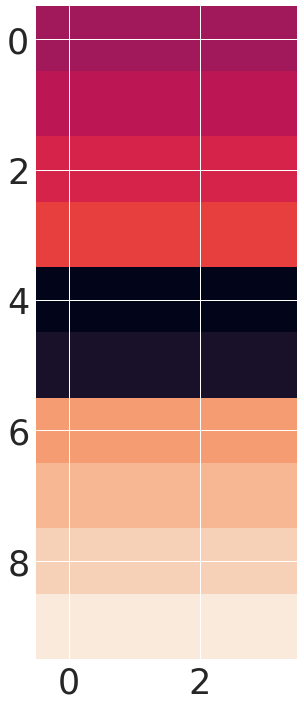

In [7]:
pprint.pprint(seq1)
pprint.pprint(seq2)
plt.imshow(seq2);

1.0


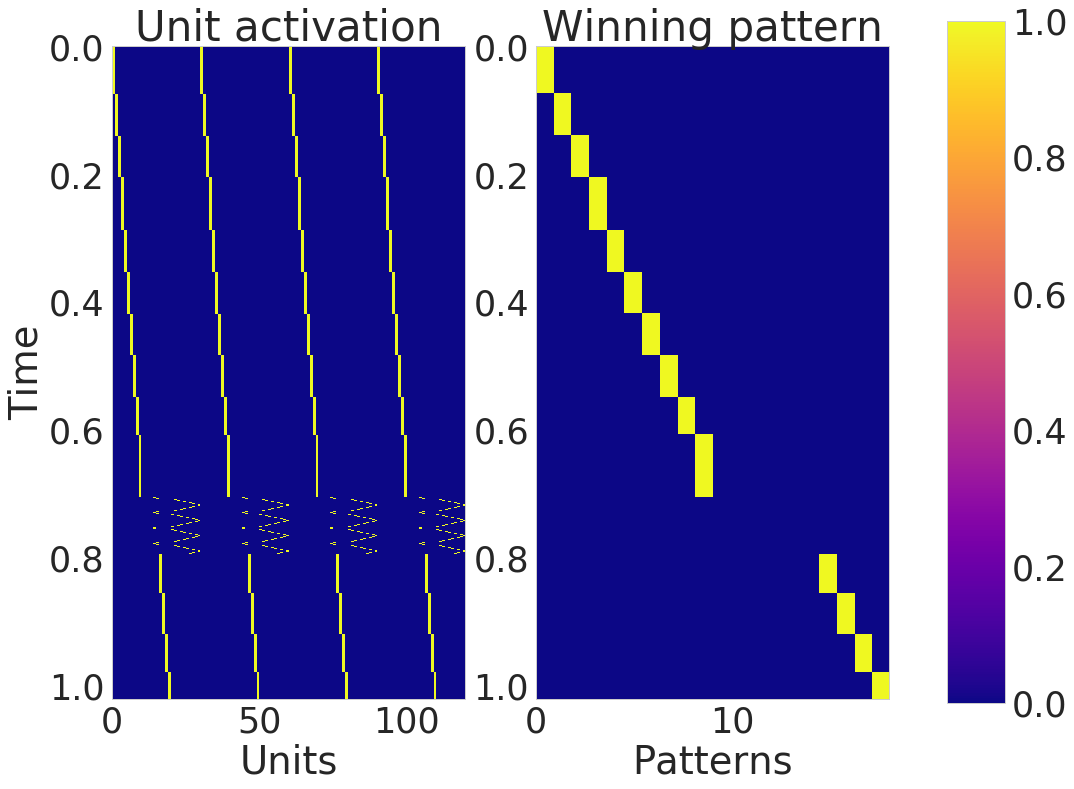

In [11]:
T_recall = 1.0
T_cue = 0.020
s = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
print(s)
plot_network_activity_angle(manager)

1.0


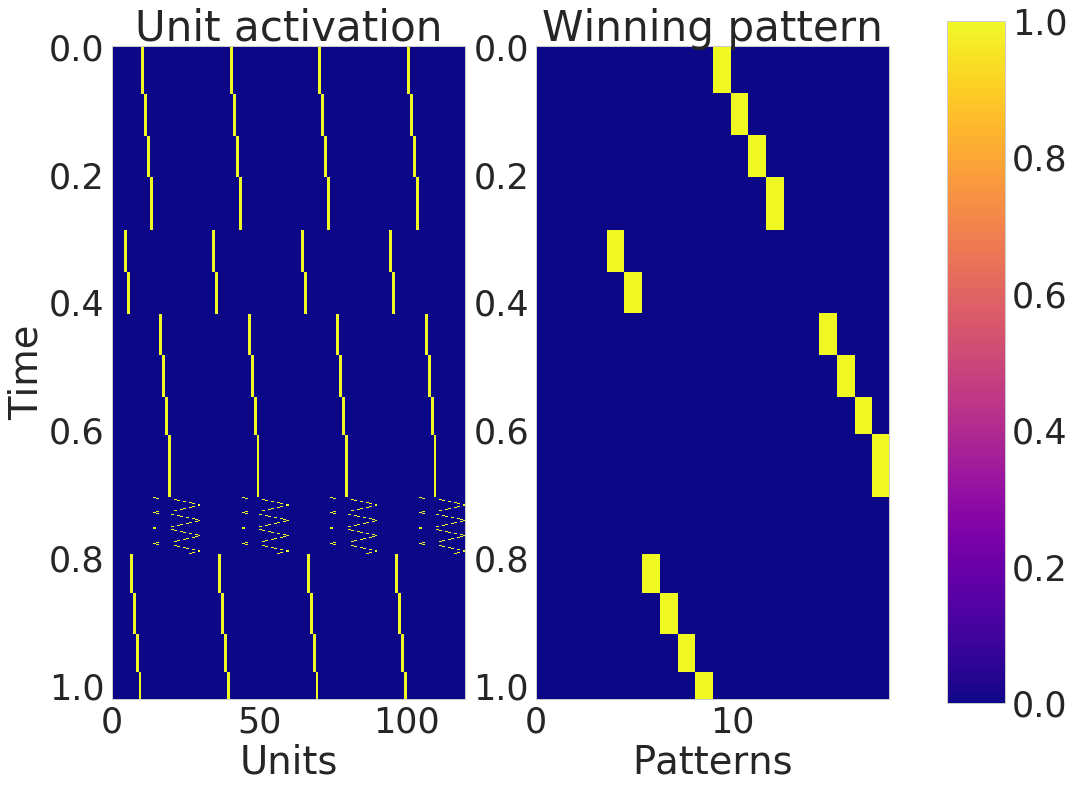

In [10]:
s = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
print(s)
plot_network_activity_angle(manager)

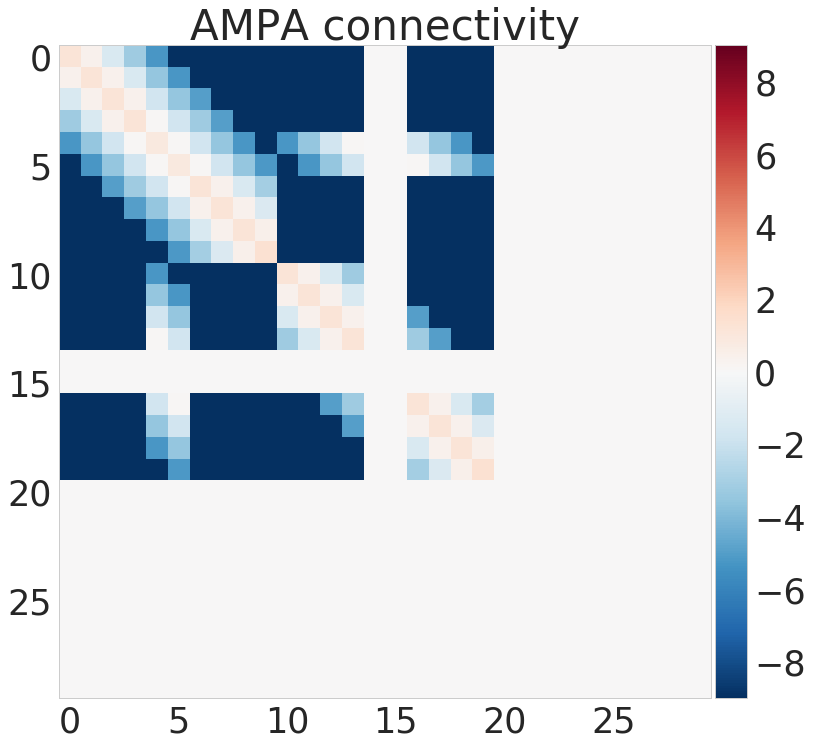

In [9]:
plot_weight_matrix(nn, ampa=True)

## More systematic

In [ ]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 4
minicolumns = 30
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
s = 1.0
r = 0.25

# Recall
T_recall = 1.0
T_cue = 0.020

num = 5
s_space = np.linspace(0, 1, num=num)
r_space = np.linspace(0, 1, num=num)
success_vector = np.zeros((num, num))

for s_index, s in enumerate(s_space):
    print(s_index)
    for r_index, r in enumerate(r_space):
        # The network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)


        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # The sequences
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                                training_time, inter_pulse_interval=inter_pulse_interval,
                                                inter_sequence_interval=inter_sequence_interval, epochs=epochs) 
        seq1, seq2, nr1, nr2, w_total, beta = aux
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        nn.w_ampa = w_total
        manager.patterns_dic = patterns_dic
        
        # Recall
        s1 = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
        s2 = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
        success_vector[s_index, r_index] = 0.5 * (s1 + s2)